<a href="https://colab.research.google.com/github/Kutayalptekinn/AI-Projects/blob/main/survival_analiz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##ANALİZ

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19               # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50         # ResNet50
from tensorflow.keras.applications.mobilenet import MobileNet       # MobileNet
from tensorflow.keras.applications.densenet import DenseNet169      # DenseNet169
from tensorflow.keras.applications import EfficientNetB0            # EfficientNetB0
from tensorflow.keras.applications import InceptionV3               # ınceprionV3
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import pathlib
import PIL
from PIL import Image

import cv2
import pandas as pd
import os
import random
import csv
import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
img_width, img_height = 256,357 #width & height of input image
input_depth = 3 #1: gray image
Dataset_Analiz_dir = '/content/drive/MyDrive/Dataset_Analiz'
batchSize = 10 #training batch size
batch_size = 10
data_dir = pathlib.Path(Dataset_Analiz_dir) # SELECT DATASET SOURCE

##DATASET HAZIRLAMA

In [ ]:
# Veri klasörlerinin yollarını belirleme

train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'val')

# Hasta insanların klasörlerinin yollarını belirleme
sick_dir = os.path.join(data_dir, 'patient')

# Tüm hastaları ve sağlıklı insanları bir listeye yerleştirme
sick_people = [os.path.join(sick_dir, f) for f in os.listdir(sick_dir)]
#random dağıt
random.shuffle(sick_people)

# Train, test ve val bölümlerini ayırma
train_people = sick_people[:90]
val_people = sick_people[90:124]
test_people = sick_people[124:148]



In [ ]:


# CSV dosyaları oluşturma
def create_csv(file_name, people_list):
    with open(file_name, mode='w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(["img", "status"])
        for person in people_list:
              for imgs in os.listdir(person):

                  if "horizontal" in imgs:
                      last_part = imgs.split("_")[1]
                  else:
                      last_part = person.split("_")[-1]

                  # Remove any non-digit characters from the last part
                  number = "".join(filter(str.isdigit, last_part))
                  number = int(number)

                  if number > 0 and number <= 360:
                      label = 0
                  elif number > 360 and number <= 720:
                      label = 1
                  elif number > 720 and number <= 1800:
                      label = 2

                  # Write original image path and label
                  writer.writerow([person+"/"+imgs, label])

                  ## Aşağıdaki 16 satırlık işlemler 1 kereliğine verisetini arttırmak amacıyla uygulanıp yorum satırına alınır
                  # Apply horizontal flip to the image
                  img = Image.open(person+"/"+imgs)
                  img_horizontal = img.transpose(Image.FLIP_LEFT_RIGHT)
                  output_directory = os.path.join(data_dir, "train", person+"_horizontal")
                  os.makedirs(output_directory, exist_ok=True)
                  # Generate new filename for the horizontal flipped image
                  img_filename = os.path.splitext(imgs)[0]  # Dosya adını alın
                  img_extension = os.path.splitext(imgs)[1]  # Dosya uzantısını alın
                  img_horizontal_filename = f"{img_filename}_horizontal{img_extension}"
                  img_horizontal_path = os.path.join(output_directory, img_horizontal_filename)

                  # Save the horizontal flipped image
                  img_horizontal.save(img_horizontal_path)
                  # Write horizontal flipped image path and label
                  writer.writerow([os.path.join(person, img_horizontal_filename), label])
                  ##

try:
  os.makedirs(os.path.join(data_dir,"/train"))
  os.makedirs(os.path.join(data_dir,"/test"))
  os.makedirs(os.path.join(data_dir,"/val"))
  # os.makedirs(data_dir+"/train")
  # os.makedirs(data_dir+"/test")
  # os.makedirs(data_dir+"/val")
except OSError:
  pass

create_csv(os.path.join(train_dir, 'train.csv'), train_people)
create_csv(os.path.join(test_dir, 'test.csv'), test_people)
create_csv(os.path.join(val_dir, 'val.csv'), val_people)

In [ ]:
train_df = pd.read_csv(os.path.join(train_dir,'train.csv'))
val_df = pd.read_csv(os.path.join(val_dir,'val.csv'))
test_df = pd.read_csv(os.path.join(test_dir,'test.csv'))

train_labels = to_categorical(train_df['status'])
val_labels = to_categorical(val_df['status'])
test_labels = to_categorical(test_df['status'])

train_df['status'] = train_df['status'].astype(str)
val_df['status'] = val_df['status'].astype(str)
test_df['status'] = test_df['status'].astype(str)

train_datagen = ImageDataGenerator(
    shear_range=0.2,  # Kesme dönüşümü
    zoom_range=0.2,
    horizontal_flip=True)  # Rastgele yakınlaştırma
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [ ]:

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="img", y_col="status", color_mode='rgb',
    target_size=(img_width, img_height),
    batch_size=batchSize,
    class_mode='categorical',
    shuffle=True,
    seed=123
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="img", y_col="status", color_mode='rgb',
    target_size=(img_width, img_height),
    batch_size=batchSize,
    class_mode='categorical',
    shuffle=True,
    seed=123
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="img", y_col="status", color_mode='rgb',
    target_size=(img_width, img_height),
    batch_size=batchSize,
    class_mode='categorical',
    shuffle=True,
    seed=123
)

Found 900 validated image filenames belonging to 3 classes.
Found 340 validated image filenames belonging to 3 classes.
Found 240 validated image filenames belonging to 3 classes.


In [ ]:
train_ds = train_generator

val_ds = val_generator

test_ds = test_generator

##MODEL EĞİTİMİ

# Costum model

In [ ]:
model = models.Sequential([
  layers.Rescaling(1./255, input_shape=(img_width, img_height, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(3,activation='softmax')
])

# Freeze the layers before the last convolutional layer
# for layer in model.layers[:-6]:
#     layer.trainable = False

# base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# # VGG19 modelinin üzerine eklenen katmanlar
# model = models.Sequential()
# model.add(base_model)
# model.add(layers.Flatten())
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dense(3, activation='softmax'))


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, min_delta=0)

In [ ]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callback
)


Epoch 1/50
90/90 [==============================] - 103s 1s/step - loss: 1.3615 - accuracy: 0.5122 - val_loss: 1.0919 - val_accuracy: 0.3735
Epoch 2/50
90/90 [==============================] - 108s 1s/step - loss: 0.8773 - accuracy: 0.6000 - val_loss: 1.0468 - val_accuracy: 0.5912
Epoch 3/50
90/90 [==============================] - 106s 1s/step - loss: 0.6951 - accuracy: 0.6733 - val_loss: 1.0526 - val_accuracy: 0.6029
Epoch 4/50
90/90 [==============================] - 105s 1s/step - loss: 0.5856 - accuracy: 0.7489 - val_loss: 1.0248 - val_accuracy: 0.6500
Epoch 5/50
90/90 [==============================] - 106s 1s/step - loss: 0.4956 - accuracy: 0.7944 - val_loss: 0.8287 - val_accuracy: 0.6676
Epoch 6/50
90/90 [==============================] - 105s 1s/step - loss: 0.4856 - accuracy: 0.8022 - val_loss: 1.0020 - val_accuracy: 0.5853
Epoch 7/50
90/90 [==============================] - 104s 1s/step - loss: 0.4054 - accuracy: 0.8467 - val_loss: 1.1384 - val_accuracy: 0.6471
Epoch 8/50
90

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

24/24 [==============================] - 11s 477ms/step - loss: 1.5167 - accuracy: 0.7083
Test Loss: 1.5166971683502197
Test Accuracy: 0.7083333134651184


#VGG19

In [ ]:
# VGG19 modeli
base_model = VGG19(input_shape=(img_width, img_height, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(3, activation='softmax')(x)

model = models.Model(base_model.input, x)
model.summary()

80134624/80134624 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 357, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 357, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 357, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 178, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 178, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 178, 128)     147584    
                                                              

In [ ]:
# Modeli derleme ve eğitim
#model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy(from_logits=True), metrics=['accuracy'])
#model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=20,min_delta=0,
                                            restore_best_weights=True)

In [ ]:
epochs = 100
print(len(train_ds))
print(len(val_ds))

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callback
)

90
34
Epoch 1/100
90/90 [==============================] - 1187s 13s/step - loss: 4.5993 - accuracy: 0.7556 - val_loss: 3.4442 - val_accuracy: 0.7559
Epoch 2/100
90/90 [==============================] - 1186s 13s/step - loss: 0.6452 - accuracy: 0.9211 - val_loss: 2.0560 - val_accuracy: 0.7588
Epoch 3/100
90/90 [==============================] - 1189s 13s/step - loss: 0.4784 - accuracy: 0.9367 - val_loss: 2.2225 - val_accuracy: 0.7853
Epoch 4/100
90/90 [==============================] - 1185s 13s/step - loss: 0.5839 - accuracy: 0.9311 - val_loss: 1.4088 - val_accuracy: 0.8265
Epoch 5/100
90/90 [==============================] - 1178s 13s/step - loss: 0.2367 - accuracy: 0.9567 - val_loss: 0.8249 - val_accuracy: 0.8206
Epoch 6/100
90/90 [==============================] - 1183s 13s/step - loss: 0.1754 - accuracy: 0.9633 - val_loss: 1.3136 - val_accuracy: 0.7912
Epoch 7/100
90/90 [==============================] - 1192s 13s/step - loss: 0.0884 - accuracy: 0.9733 - val_loss: 1.7854 - val_acc

KeyboardInterrupt: ignored

# K-Flod Validation

In [ ]:
# Veri klasörlerinin yollarını belirleme

train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'val')

# Hasta insanların klasörlerinin yollarını belirleme
sick_dir = os.path.join(data_dir, 'patient')

# Tüm hastaları ve sağlıklı insanları bir listeye yerleştirme
sick_people = [os.path.join(sick_dir, f) for f in os.listdir(sick_dir)]
#random dağıt
random.shuffle(sick_people)

train_df = pd.read_csv(os.path.join(train_dir,'train.csv'))
val_df = pd.read_csv(os.path.join(val_dir,'val.csv'))
test_df = pd.read_csv(os.path.join(test_dir,'test.csv'))

train_labels = to_categorical(train_df['status'])
val_labels = to_categorical(val_df['status'])
test_labels = to_categorical(test_df['status'])

train_df['status'] = train_df['status'].astype(str)
val_df['status'] = val_df['status'].astype(str)
test_df['status'] = test_df['status'].astype(str)


datagen = ImageDataGenerator()
# DataFrame'leri birleştirme
merged_df = pd.concat([train_df, val_df, test_df], ignore_index=True)




In [ ]:
Labels = train_df['status'].unique().tolist()

# Store loss values
epochsK = []
train_loss = []
val_loss = []

# Create K-fold object
k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=42)

# Iterate over each fold
fold_no = 1


In [ ]:
for train_index, val_index in kfold.split(merged_df):
    print(f'Step {fold_no}: \n')
    fold_no += 1

    # Split data into training and validation sets
    train_data = merged_df.iloc[train_index]
    val_data = merged_df.iloc[val_index]

    # Create data generators for training and validation
    train_generator = datagen.flow_from_dataframe(
        dataframe=train_data,
        x_col="img",
        y_col="status",
        color_mode='rgb',
        target_size=(img_width, img_height),
        batch_size=batchSize,
        class_mode='categorical',
        shuffle=True,
        seed=123
    )

    val_generator = datagen.flow_from_dataframe(
        dataframe=val_data,
        x_col="img",
        y_col="status",
        color_mode='rgb',
        target_size=(img_width, img_height),
        batch_size=batchSize,
        class_mode='categorical',
        shuffle=True,
        seed=123
    )

    # Model creation
    base_model = VGG19(input_shape=(img_width, img_height, 3), include_top=False, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False

    x = layers.Flatten()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(len(Labels), activation='softmax')(x)

    model = models.Model(base_model.input, x)

    model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

    epochs = 50
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[callback]
    )

    epochsK.append(len(history.history['loss']))
    train_loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])

    print("___________________________________________________________________________")

Step 1: 

Found 1184 validated image filenames belonging to 3 classes.
Found 296 validated image filenames belonging to 3 classes.
80134624/80134624 [==============================] - 2s 0us/step
Epoch 1/50
119/119 [==============================] - 2408s 20s/step - loss: 4.5777 - accuracy: 0.7762 - val_loss: 0.3339 - val_accuracy: 0.9257
Epoch 2/50
119/119 [==============================] - 2416s 20s/step - loss: 0.1799 - accuracy: 0.9603 - val_loss: 0.2773 - val_accuracy: 0.9493
Epoch 3/50
119/119 [==============================] - 2404s 20s/step - loss: 0.0386 - accuracy: 0.9890 - val_loss: 0.1853 - val_accuracy: 0.9595
Epoch 4/50
119/119 [==============================] - 2370s 20s/step - loss: 0.0300 - accuracy: 0.9890 - val_loss: 0.1907 - val_accuracy: 0.9595
Epoch 5/50
119/119 [==============================] - 2311s 19s/step - loss: 0.0034 - accuracy: 0.9983 - val_loss: 0.1623 - val_accuracy: 0.9764
Epoch 6/50
119/119 [==============================] - 2232s 19s/step - loss: 2.

[0.20414902 0.         0.         0.         0.         0.
 0.         0.         0.        ] [0.20414902 0.         0.         0.         0.         0.
 0.         0.         0.        ]


ValueError: ignored

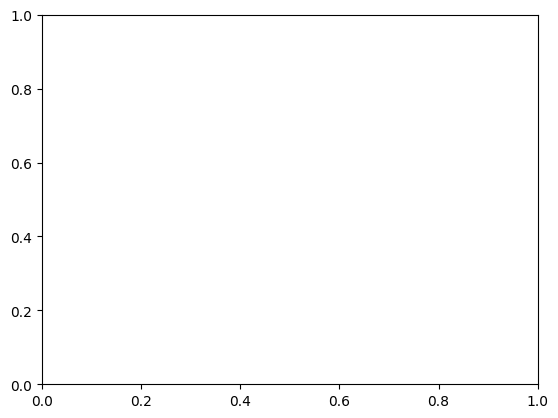

In [ ]:
# Ortalama eğitim ve doğrulama kayıplarını hesaplama
avg_train_loss = np.mean(train_loss, axis=0)
avg_val_loss = np.mean(val_loss, axis=0)
print(avg_train_loss,avg_train_loss)

# Kayıp grafiğini çizme
plt.plot(range(1, sum(epochsK)+1), avg_train_loss, label='Training Loss')
plt.plot(range(1, sum(epochsK)+1), avg_val_loss, label='Validation Loss')
plt.title('Cross Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

# Convert train_ds to numpy arrays
train_images = np.array([image for image, _ in train_ds])
train_labels = np.array([label for _, label in train_ds])

# Extract the image paths from val_ds and test_ds
val_paths = val_ds.filepaths
test_paths = test_ds.filepaths

# Extract the labels from val_ds and test_ds
val_labels = val_ds.labels
test_labels = test_ds.labels

# Combine val_paths and val_labels into a list of tuples
val_data = list(zip(val_paths, val_labels))

# Combine test_paths and test_labels into a list of tuples
test_data = list(zip(test_paths, test_labels))

# Define the number of folds
k = 5

train_labels_int = np.argmax(train_labels, axis=1)

# Perform k-fold cross-validation
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=123)

for fold, (train_index, val_index) in enumerate(skf.split(train_images, train_labels_int)):
    print(f'Fold: {fold + 1}')

    # Split the training data into training and validation sets
    fold_train_images, fold_train_labels = train_images[train_index], train_labels[train_index]
    fold_val_images, fold_val_labels = train_images[val_index], train_labels[val_index]

    # Create tf.data.Dataset for the fold
    fold_train_ds = tf.data.Dataset.from_tensor_slices((fold_train_images, fold_train_labels))
    fold_val_ds = tf.data.Dataset.from_tensor_slices((fold_val_images, fold_val_labels))

    # print(fold_val_labels)
    # plt.imshow(fold_train_images[0])  # Use 'gray' colormap for grayscale images
    # plt.axis('off')  # Turn off the axes
    # plt.show()

    IMG_SIZE = (180, 180)
    img_height = 180
    img_width = 180

    model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
        layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(256, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Create a new directory for the current fold
    fold_dir = os.path.join(data_dir, f'fold_{fold + 1}')
    os.makedirs(fold_dir, exist_ok=True)

    # Train the model
    history = model.fit(
        fold_train_ds,
        validation_data=fold_val_ds,
        epochs=epochs,
        callbacks=[callback]
    )

    epochsK.append(len(history.history['loss']))
    train_loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])

    print("___________________________________________________________________________")

KeyboardInterrupt: ignored

# deneme

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

# Convert train_ds to numpy arrays
train_images = np.array([image for image, _ in train_ds])
train_labels = np.array([label for _, label in train_ds])

# Extract the image paths from val_ds and test_ds
val_paths = val_ds.filepaths
test_paths = test_ds.filepaths

# Extract the labels from val_ds and test_ds
val_labels = val_ds.labels
test_labels = test_ds.labels

# Combine val_paths and val_labels into a list of tuples
val_data = list(zip(val_paths, val_labels))

# Combine test_paths and test_labels into a list of tuples
test_data = list(zip(test_paths, test_labels))

# Define the number of folds
k = 5

train_labels_int = np.argmax(train_labels, axis=1)

# Perform k-fold cross-validation
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=123)

for fold, (train_index, val_index) in enumerate(skf.split(train_images, train_labels_int)):
    print(f'Fold: {fold + 1}')

    # Split the training data into training and validation sets
    fold_train_images, fold_train_labels = train_images[train_index], train_labels[train_index]
    fold_val_images, fold_val_labels = train_images[val_index], train_labels[val_index]

    # Create tf.data.Dataset for the fold
    fold_train_ds = tf.data.Dataset.from_tensor_slices((fold_train_images, fold_train_labels))
    fold_val_ds = tf.data.Dataset.from_tensor_slices((fold_val_images, fold_val_labels))

    # print(fold_val_labels)
    # plt.imshow(fold_train_images[0])  # Use 'gray' colormap for grayscale images
    # plt.axis('off')  # Turn off the axes
    # plt.show()

    IMG_SIZE = (180, 180)
    img_height = 180
    img_width = 180

    base_model = VGG19(input_shape=(img_width, img_height, 3), include_top=False, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False

    x = layers.Flatten()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(3, activation='softmax')(x)

    model = models.Model(base_model.input, x)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=20,min_delta=0,
                                                restore_best_weights=True)

    # Create a new directory for the current fold
    fold_dir = os.path.join(data_dir, f'fold_{fold + 1}')
    os.makedirs(fold_dir, exist_ok=True)

    # Train the model
    epochs = 100

    history = model.fit(
      fold_train_images, fold_val_images,
      validation_data=(fold_val_images, fold_val_labels),
      epochs=epochs,
      callbacks=callback
    )

    epochsK.append(len(history.history['loss']))
    train_loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])

    print("___________________________________________________________________________")

NameError: ignored